In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt
from fpfs.simutil import LensTransform

from scipy.optimize import curve_fit


In [2]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

### these sets of numbers gives perfect gamma^3 fitting ###
flux = 40
nn = 100
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=5)
scale = 0.1 # 0.15 gives really small bias but the form is third order in g1 
G1 = 0.000 ### fixing Flexion for now, this is in order to test whether there are some intrinsic bias 
### in our simulation setup
G2 = 0.000
F1 = 0.000
F2 = 0.000 
### these sets of numbers gives perfect gamma^3 fitting ###


# flux = 40
# nn = 100
# sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=5)
# scale = 0.15 # 0.15 gives really small bias but the form is third order in g1 
# G1 = 0.000 ### fixing Flexion for now, this is in order to test whether there are some intrinsic bias 
# ### in our simulation setup
# G2 = 0.000
# F1 = 0.000
# F2 = 0.000 

In [3]:
# """Original galaxy"""
# flux = 40
# scale = 0.01#sampling make smaller, answer don't change -> convergence test
# nn = 200#64
# sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=4)
# stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
# gal_array = stamp.sample_galaxy(sersic_gal)
# plt.close()
# fpfs.pltutil.make_plot_image(gal_array)

In [4]:
### to determine additive bias.
kappa = 0.00
gamma1 = 0.0
gamma2 = 0.0
#scale_array = np.logspace(np.log10(0.01),np.log10(0.2),50)


lens = LensTransform(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
stamp.transform_grids(lens)
gal_array3 = stamp.sample_galaxy(sersic_gal)
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1
coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.52)
mms =  fpTask.measure(gal_array3, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
resp1=np.average(ells['fpfs_R1E'])
shear1=np.average(ells['fpfs_e1'])/resp1
c1 = shear1 
del stamp
del lens

I0000 00:00:1699515065.495524   27328 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [5]:
### determine multiplicative bias for different value of gamma1

kappa = 0.00
gamma1_array = np.linspace(0.00001,0.15,50)
gamma1_measured_array = np.zeros_like(gamma1_array)
gamma2 = 0.0
#scale_array = np.logspace(np.log10(0.01),np.log10(0.2),50)
for i in range(len(gamma1_array)):
    lens = LensTransform(gamma1=gamma1_array[i], gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
    stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
    stamp.transform_grids(lens)
    gal_array3 = stamp.sample_galaxy(sersic_gal)
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.52)
    mms =  fpTask.measure(gal_array3, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
    resp1=np.average(ells['fpfs_R1E'])
    shear1=np.average(ells['fpfs_e1'])/resp1
    gamma1_measured_array[i] = shear1 
    del stamp
    del lens

In [6]:
def model_3(x, a):
    return a * x**3
def model_2(x, a):
    return a * x**2

coefficient with just the second order term: -0.45560007664191354
coefficient with just the third order term: -3.5113322762784716


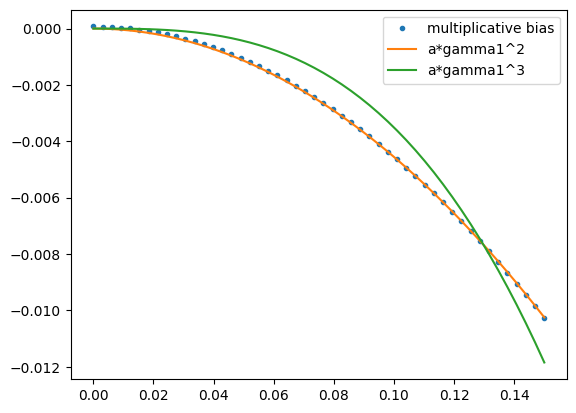

In [7]:
m1 = (gamma1_measured_array-c1-gamma1_array)/gamma1_array

# Perform the curve fit
params3, covariance3 = curve_fit(model_3, gamma1_array, m1)
params2, covariance2 = curve_fit(model_2, gamma1_array, m1)
# Get the estimated value of 'a'
estimated_a3 = params3[0]
estimated_a2 = params2[0]


print(f'coefficient with just the second order term: {estimated_a2}')
print(f'coefficient with just the third order term: {estimated_a3}')

plt.plot(gamma1_array,m1,'.',label='multiplicative bias')
plt.plot(gamma1_array, model_2(gamma1_array, estimated_a2), label='a*gamma1^2')
plt.plot(gamma1_array, model_3(gamma1_array, estimated_a3), label='a*gamma1^3')
plt.legend()
plt.show()
